# Project B: Knowledge Distillation for Building Lightweight Deep Learning Models in Visual Classification Tasks

In [3]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
from tensorflow.core.util import event_pb2
#import tensorflow
import keras
from tensorflow.python.lib.io import tf_record
from typing import Union
import numpy as np
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir(r'/content/drive/My Drive/ECE1512')
tf.enable_v2_behavior()

builder = tfds.builder('mnist')
BATCH_SIZE = 256
NUM_EPOCHS = 12
NUM_CLASSES = 10  # 10 total classes.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from tensorflow import keras
from keras.models import load_model
from tensorflow.keras import layers
#from keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import Adam

# Data loading

In [5]:
# Load train and test splits.
def preprocess(x):
  image = tf.image.convert_image_dtype(x['image'], tf.float32)
  class_labels = tf.one_hot(x['label'], builder.info.features['label'].num_classes)
  return image, class_labels


mnist_train = tfds.load('mnist', split='train', shuffle_files=False).cache()
mnist_train = mnist_train.map(preprocess)
mnist_train = mnist_train.shuffle(builder.info.splits['train'].num_examples)
mnist_train = mnist_train.batch(BATCH_SIZE, drop_remainder=True)

mnist_test = tfds.load('mnist', split='test').cache()


In [6]:
mnist_test = mnist_test.map(preprocess).batch(BATCH_SIZE)

In [25]:
mnist_test

<BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

# Model creation

## Model Teacher and student for KD

In [ ]:
# Build CNN teacher.
#cnn_model = tf.keras.Sequential()

# your code start from here for stpe 2
teacher = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(32, (3, 3), strides=(1, 1), padding="same"),
        layers.ReLU(),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        layers.Conv2D(64, (3, 3), strides=(1, 1), padding="same"),
        layers.ReLU(),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(10)
    ],
    name="teacher",
)


# Build fully connected student.
#fc_model = tf.keras.Sequential()


# your code start from here for step 2

student = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Flatten(),
        layers.Dense(784, activation="relu"),
        layers.Dense(784, activation="relu"),
        layers.Dense(10)

    ],
    name="student",
)




In [ ]:
student = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Flatten(),
        layers.Dense(784, activation="relu"),
        layers.Dense(784, activation="relu"),
        layers.Dense(10)

    ],
    name="student",
)



In [ ]:
teacher.summary()

Model: "teacher"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 re_lu (ReLU)                (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 28, 28, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 re_lu_1 (ReLU)              (None, 28, 28, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                       

## Models for new KD

### Teacher assistant for new kd loss: 0.0616 - accuracy: 0.9817 - val_loss: 0.0554 - val_accuracy: 0.9835

In [ ]:
teacher_ast = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(32, (3, 3), strides=(1, 1), padding="same"),
        layers.ReLU(),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        # layers.Conv2D(64, (3, 3), strides=(1, 1), padding="same"),
        # layers.ReLU(),
        #layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),
        layers.Flatten(),
        layers.Dropout(0.5),
        #layers.Dense(128, activation="relu"),
        # layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ],
    name="teacher_ast",
)

In [ ]:
teacher_ast.summary()

Model: "teacher_ast"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 re_lu_2 (ReLU)              (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_2 (Dropout)         (None, 25088)             0         
                                                                 
 dense_5 (Dense)             (None, 10)                250890    
                                                       

In [ ]:
teacher_ast.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

In [ ]:
teacher_ast.fit(mnist_train, epochs=5,validation_data=mnist_test)

Epoch 1/5
234/234 [==============================] - 63s 259ms/step - loss: 0.3021 - accuracy: 0.9111 - val_loss: 0.1230 - val_accuracy: 0.9666
Epoch 2/5
234/234 [==============================] - 62s 255ms/step - loss: 0.1101 - accuracy: 0.9682 - val_loss: 0.0787 - val_accuracy: 0.9769
Epoch 3/5
234/234 [==============================] - 61s 253ms/step - loss: 0.0815 - accuracy: 0.9764 - val_loss: 0.0649 - val_accuracy: 0.9800
Epoch 4/5
234/234 [==============================] - 61s 253ms/step - loss: 0.0695 - accuracy: 0.9795 - val_loss: 0.0558 - val_accuracy: 0.9827
Epoch 5/5
234/234 [==============================] - 61s 253ms/step - loss: 0.0616 - accuracy: 0.9817 - val_loss: 0.0554 - val_accuracy: 0.9835


### Teacher for new kd loss: 0.0500 - accuracy: 0.9848 - val_loss: 0.0267 - val_accuracy: 0.9916

In [ ]:
teacher_test = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(32, (3, 3), strides=(1, 1), padding="same"),
        layers.ReLU(),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        layers.Conv2D(64, (3, 3), strides=(1, 1), padding="same"),
        layers.ReLU(),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(10,activation="softmax")
    ],
    name="teacher_test",
)

In [ ]:
teacher_test.summary()

Model: "teacher_test"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 re_lu_5 (ReLU)              (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 28, 28, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 re_lu_6 (ReLU)              (None, 28, 28, 64)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                  

In [ ]:
teacher_test.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

In [ ]:
teacher_test.fit(mnist_train, epochs=5,validation_data=mnist_test)

Epoch 1/5
234/234 [==============================] - 206s 870ms/step - loss: 0.2944 - accuracy: 0.9092 - val_loss: 0.0554 - val_accuracy: 0.9817
Epoch 2/5
234/234 [==============================] - 205s 867ms/step - loss: 0.0940 - accuracy: 0.9710 - val_loss: 0.0390 - val_accuracy: 0.9868
Epoch 3/5
234/234 [==============================] - 205s 868ms/step - loss: 0.0733 - accuracy: 0.9788 - val_loss: 0.0344 - val_accuracy: 0.9885
Epoch 4/5
234/234 [==============================] - 205s 869ms/step - loss: 0.0588 - accuracy: 0.9823 - val_loss: 0.0297 - val_accuracy: 0.9901
Epoch 5/5
234/234 [==============================] - 203s 862ms/step - loss: 0.0500 - accuracy: 0.9848 - val_loss: 0.0267 - val_accuracy: 0.9916


### Student fro new kd  loss: 0.0243 - accuracy: 0.9921 - val_loss: 0.0673 - val_accuracy: 0.9805

In [ ]:
student_2_kdd = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Flatten(),
        layers.Dense(784, activation="relu"),
        layers.Dense(784, activation="relu"),
        layers.Dense(10, activation="softmax")

    ],
    name="student_2_kdd",
)


In [ ]:
student_2_kdd.summary()

Model: "student_2_kdd"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_13 (Flatten)        (None, 784)               0         
                                                                 
 dense_24 (Dense)            (None, 784)               615440    
                                                                 
 dense_25 (Dense)            (None, 784)               615440    
                                                                 
 dense_26 (Dense)            (None, 10)                7850      
                                                                 
Total params: 1,238,730
Trainable params: 1,238,730
Non-trainable params: 0
_________________________________________________________________


In [ ]:
student_2_kdd.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

In [ ]:
student_2_kdd.fit(mnist_train, epochs=5,validation_data=mnist_test)

Epoch 1/5
234/234 [==============================] - 13s 44ms/step - loss: 0.2346 - accuracy: 0.9306 - val_loss: 0.1023 - val_accuracy: 0.9679
Epoch 2/5
234/234 [==============================] - 12s 43ms/step - loss: 0.0789 - accuracy: 0.9753 - val_loss: 0.0768 - val_accuracy: 0.9758
Epoch 3/5
234/234 [==============================] - 12s 43ms/step - loss: 0.0476 - accuracy: 0.9852 - val_loss: 0.0754 - val_accuracy: 0.9753
Epoch 4/5
234/234 [==============================] - 12s 44ms/step - loss: 0.0330 - accuracy: 0.9896 - val_loss: 0.0635 - val_accuracy: 0.9804
Epoch 5/5
234/234 [==============================] - 12s 43ms/step - loss: 0.0243 - accuracy: 0.9921 - val_loss: 0.0673 - val_accuracy: 0.9805


# Teacher loss function

In [24]:

def compute_teacher_loss(images, labels,temperature,alpha):
  """Compute class knowledge distillation teacher loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  class_logits = teacher(images, training=True)

  # Compute cross-entropy loss for classes.

  # your code start from here for step 3

  cross_entropy_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels,class_logits))

  return cross_entropy_loss_value

# Student loss function

In [23]:
# Hyperparameters for distillation (need to be tuned).
# ALPHA = 0.5 # task balance between cross-entropy and distillation loss
# DISTILLATION_TEMPERATURE = 4. #temperature hyperparameter

def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
  """Compute distillation loss.

  This function computes cross entropy between softened logits and softened
  targets. The resulting loss is scaled by the squared temperature so that
  the gradient magnitude remains approximately constant as the temperature is
  changed. For reference, see Hinton et al., 2014, "Distilling the knowledge in
  a neural network."

  Args:
    teacher_logits: A Tensor of logits provided by the teacher.
    student_logits: A Tensor of logits provided by the student, of the same
      shape as `teacher_logits`.
    temperature: Temperature to use for distillation.

  Returns:
    A scalar Tensor containing the distillation loss.
  """
 # your code start from here for step 3
  soft_targets = teacher_logits / temperature
  soft_targets =tf.nn.softmax(soft_targets)
  return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          soft_targets, student_logits / temperature))*temperature**2
  #* temperature ** 2

def compute_student_loss(images, labels,temperature,alpha):
  """Compute class knowledge distillation student loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  student_class_logits = student(images, training=True)

  # Compute class distillation loss between student class logits and
  # softened teacher class targets probabilities.

  # your code start from here for step 3

  teacher_class_logits = teacher(images, training=False)
  distillation_loss_value =distillation_loss(teacher_class_logits,student_class_logits,temperature)

  # Compute cross-entropy loss with hard targets.

  # your code start from here for step 3

 
  cross_entropy_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, student_class_logits))

  total_loss =alpha*cross_entropy_loss_value + (1-alpha)*distillation_loss_value

  return total_loss

# Train and evaluation

### TRAINING and EVALUATE FUNCTION

In [25]:
# your code start from here for step 5 

@tf.function
def compute_num_correct(model, images, labels):
  """Compute number of correctly classified images in a batch.

  Args:
    model: Instance of tf.keras.Model.
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Number of correctly classified images.
  """
  class_logits = model(images, training=False)
  return tf.reduce_sum(
      tf.cast(tf.math.equal(tf.argmax(class_logits, -1), tf.argmax(labels, -1)),
              tf.float32)), tf.argmax(class_logits, -1), tf.argmax(labels, -1)
              
def train_and_evaluate(model, compute_loss_fn,temperature,learning_rate,alpha):
  """Perform training and evaluation for a given model.

  Args:
    model: Instance of tf.keras.Model.
    compute_loss_fn: A function that computes the training loss given the
      images, and labels.
  """
 
  # your code start from here for step 4
  optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

  for epoch in range(1, NUM_EPOCHS + 1):
    # Run training.
    print('Epoch {}: '.format(epoch), end='')
    for images, labels in mnist_train:
      with tf.GradientTape() as tape:
         # your code start from here for step 4
          
          loss_value = compute_loss_fn(images,labels,temperature,alpha)

      grads = tape.gradient(loss_value, model.trainable_variables)
      # grads = [gradient*(1) for gradient in grads]
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

      
    # Run evaluation.
    num_correct = 0
    num_total = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:
    #   # your code start from here for step 4

      num_correct += compute_num_correct(model,images,labels)[0]
      
    print("Class_accuracy: " + '{:.2f}%'.format(
        num_correct / num_total * 100))


## **Training models**

In [ ]:
temp=4

In [ ]:

learning_rate=0.001
alpha=0.5
print("Teacher training")
train_and_evaluate(teacher, compute_teacher_loss,temp,learning_rate,alpha)

Teacher training
Epoch 1: Class_accuracy: 98.04%
Epoch 2: Class_accuracy: 98.67%
Epoch 3: Class_accuracy: 98.82%
Epoch 4: Class_accuracy: 99.09%
Epoch 5: Class_accuracy: 99.06%
Epoch 6: Class_accuracy: 99.00%
Epoch 7: Class_accuracy: 99.19%
Epoch 8: Class_accuracy: 99.09%
Epoch 9: Class_accuracy: 99.02%
Epoch 10: Class_accuracy: 99.20%
Epoch 11: Class_accuracy: 99.16%
Epoch 12: Class_accuracy: 99.29%


In [ ]:
teacher.save("teacher_model.h5")
teacher.save_weights("teacher_model_weight")

In [ ]:
learning_rate=0.001
alpha=0.5 
temp=4
print("Student distill training")
train_and_evaluate(student, compute_student_loss,temp,learning_rate,alpha)

Student distill training
Epoch 1: Class_accuracy: 96.74%
Epoch 2: Class_accuracy: 97.88%
Epoch 3: Class_accuracy: 98.07%
Epoch 4: Class_accuracy: 98.45%
Epoch 5: Class_accuracy: 98.44%
Epoch 6: Class_accuracy: 98.65%
Epoch 7: Class_accuracy: 98.65%
Epoch 8: Class_accuracy: 98.71%
Epoch 9: Class_accuracy: 98.78%
Epoch 10: Class_accuracy: 98.73%
Epoch 11: Class_accuracy: 98.63%
Epoch 12: Class_accuracy: 98.73%


In [ ]:
student.save('student_kd_temp4.h5')
student.save_weights('student_kd_temp4_weight')

# **Test accuracy vs. tempreture curve**

## TEMP1 student KD train

In [ ]:
student_temp1 = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Flatten(),
        layers.Dense(784, activation="relu"),
        layers.Dense(784, activation="relu"),
        layers.Dense(10)

    ],
    name="student_temp1",
)


In [ ]:
student_temp1.summary()

Model: "student_temp1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 784)               0         
                                                                 
 dense_17 (Dense)            (None, 784)               615440    
                                                                 
 dense_18 (Dense)            (None, 784)               615440    
                                                                 
 dense_19 (Dense)            (None, 10)                7850      
                                                                 
Total params: 1,238,730
Trainable params: 1,238,730
Non-trainable params: 0
_________________________________________________________________


In [ ]:
teacher=load_model('./teacher_model.h5')
teacher.load_weights('./teacher_model_weight')

In [ ]:
def compute_student_loss_t1(images, labels,temperature,alpha):
  """Compute class knowledge distillation student loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  student_class_logits = student_temp1(images, training=True)

  # Compute class distillation loss between student class logits and
  # softened teacher class targets probabilities.

  # your code start from here for step 3

  teacher_class_logits = teacher(images, training=False)
  distillation_loss_value =distillation_loss(teacher_class_logits,student_class_logits,temperature)

  # Compute cross-entropy loss with hard targets.

  # your code start from here for step 3

 
  cross_entropy_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, student_class_logits))

  total_loss =alpha*cross_entropy_loss_value + (1-alpha)*distillation_loss_value

  return total_loss

In [ ]:
# your code start from here for step 6
temp=1
learning_rate=0.001
alpha=0.5
print("Student distill training")
train_and_evaluate(student_temp1,compute_student_loss_t1,temp,learning_rate,alpha)
student_temp1.save('student_kd_temp1.h5')
student_temp1.save_weights('student_kd_temp1_weight')

Student distill training
Epoch 1: Class_accuracy: 96.95%
Epoch 2: Class_accuracy: 97.83%
Epoch 3: Class_accuracy: 97.76%
Epoch 4: Class_accuracy: 98.01%
Epoch 5: Class_accuracy: 97.73%
Epoch 6: Class_accuracy: 98.29%
Epoch 7: Class_accuracy: 97.98%
Epoch 8: Class_accuracy: 98.34%
Epoch 9: Class_accuracy: 98.16%
Epoch 10: Class_accuracy: 98.17%
Epoch 11: Class_accuracy: 98.31%
Epoch 12: Class_accuracy: 98.34%


## TEMP2 student KD train

In [ ]:
student_temp2 = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Flatten(),
        layers.Dense(784, activation="relu"),
        layers.Dense(784, activation="relu"),
        layers.Dense(10)

    ],
    name="student_temp2",
)


In [ ]:
def compute_student_loss_t2(images, labels,temperature,alpha):
  """Compute class knowledge distillation student loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  student_class_logits = student_temp2(images, training=True)

  # Compute class distillation loss between student class logits and
  # softened teacher class targets probabilities.

  # your code start from here for step 3

  teacher_class_logits = teacher(images, training=False)
  distillation_loss_value =distillation_loss(teacher_class_logits,student_class_logits,temperature)

  # Compute cross-entropy loss with hard targets.

  # your code start from here for step 3

 
  cross_entropy_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, student_class_logits))

  total_loss =alpha*cross_entropy_loss_value + (1-alpha)*distillation_loss_value

  return total_loss

In [ ]:
temp=2
learning_rate=0.001
alpha=0.5
print("Student distill training")
train_and_evaluate(student_temp2, compute_student_loss_t2,temp,learning_rate,alpha)
student_temp2.save('student_kd_temp2.h5')
student_temp2.save_weights('student_kd_temp2_weight')

Student distill training
Epoch 1: Class_accuracy: 96.64%
Epoch 2: Class_accuracy: 97.59%
Epoch 3: Class_accuracy: 97.83%
Epoch 4: Class_accuracy: 98.29%
Epoch 5: Class_accuracy: 98.44%
Epoch 6: Class_accuracy: 98.48%
Epoch 7: Class_accuracy: 98.52%
Epoch 8: Class_accuracy: 98.53%
Epoch 9: Class_accuracy: 98.47%
Epoch 10: Class_accuracy: 98.55%
Epoch 11: Class_accuracy: 98.60%
Epoch 12: Class_accuracy: 98.42%


## TEMP16 student KD train

In [ ]:
student_temp16 = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Flatten(),
        layers.Dense(784, activation="relu"),
        layers.Dense(784, activation="relu"),
        layers.Dense(10)

    ],
    name="student_temp16",
)

In [49]:
def compute_student_loss_t16(images, labels,temperature,alpha):
  """Compute class knowledge distillation student loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  student_class_logits = student_temp16(images, training=True)

  # Compute class distillation loss between student class logits and
  # softened teacher class targets probabilities.

  # your code start from here for step 3

  teacher_class_logits = teacher(images, training=False)
  distillation_loss_value =distillation_loss(teacher_class_logits,student_class_logits,temperature)

  # Compute cross-entropy loss with hard targets.

  # your code start from here for step 3

 
  cross_entropy_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, student_class_logits))

  total_loss =alpha*cross_entropy_loss_value + (1-alpha)*distillation_loss_value

  return total_loss

In [ ]:
temp=16
learning_rate=0.001
alpha=0.5
print("Student distill training")
train_and_evaluate(student_temp16, compute_student_loss_t16,temp,learning_rate,alpha)
student_temp16.save('student_kd_temp16.h5')
student_temp16.save_weights('student_kd_temp16_weight')

Student distill training
Epoch 1: Class_accuracy: 96.60%
Epoch 2: Class_accuracy: 97.71%
Epoch 3: Class_accuracy: 98.39%
Epoch 4: Class_accuracy: 98.49%
Epoch 5: Class_accuracy: 98.49%
Epoch 6: Class_accuracy: 98.61%
Epoch 7: Class_accuracy: 98.68%
Epoch 8: Class_accuracy: 98.71%
Epoch 9: Class_accuracy: 98.77%
Epoch 10: Class_accuracy: 98.71%
Epoch 11: Class_accuracy: 98.85%
Epoch 12: Class_accuracy: 98.76%


## TEMP64 student KD train

In [26]:
student_temp64 = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Flatten(),
        layers.Dense(784, activation="relu"),
        layers.Dense(784, activation="relu"),
        layers.Dense(10)

    ],
    name="student_temp64",
)

In [27]:
def compute_student_loss_t64(images, labels,temperature,alpha):
  """Compute class knowledge distillation student loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  student_class_logits64 = student_temp64(images, training=True)

  # Compute class distillation loss between student class logits and
  # softened teacher class targets probabilities.

  # your code start from here for step 3

  teacher_class_logits = teacher_load(images, training=False)
  distillation_loss_value =distillation_loss(teacher_class_logits,student_class_logits64,temperature)

  # Compute cross-entropy loss with hard targets.

  # your code start from here for step 3

 
  cross_entropy_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, student_class_logits64))

  total_loss =alpha*cross_entropy_loss_value + (1-alpha)*distillation_loss_value

  return total_loss

In [30]:
temp=64
learning_rate=0.001
alpha=0.5
print("Student distill training")
train_and_evaluate(student_temp64, compute_student_loss_t64,temp,learning_rate,alpha)
student_temp64.save('student_kd_temp64.h5')
student_temp64.save_weights('student_kd_temp64_weight')

Student distill training
Epoch 1: Class_accuracy: 96.76%
Epoch 2: Class_accuracy: 98.10%
Epoch 3: Class_accuracy: 98.29%
Epoch 4: Class_accuracy: 98.47%
Epoch 5: Class_accuracy: 98.66%
Epoch 6: Class_accuracy: 98.72%
Epoch 7: Class_accuracy: 98.72%
Epoch 8: Class_accuracy: 98.74%
Epoch 9: Class_accuracy: 98.83%
Epoch 10: Class_accuracy: 98.83%
Epoch 11: Class_accuracy: 98.81%
Epoch 12: Class_accuracy: 98.92%


## TEMP32 student KD train

In [ ]:
student_temp32 = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Flatten(),
        layers.Dense(784, activation="relu"),
        layers.Dense(784, activation="relu"),
        layers.Dense(10)

    ],
    name="student_temp32",
)

In [ ]:
def compute_student_loss_t32(images, labels,temperature,alpha):
  """Compute class knowledge distillation student loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  student_class_logits = student_temp32(images, training=True)

  # Compute class distillation loss between student class logits and
  # softened teacher class targets probabilities.

  # your code start from here for step 3

  teacher_class_logits = teacher(images, training=False)
  distillation_loss_value =distillation_loss(teacher_class_logits,student_class_logits,temperature)

  # Compute cross-entropy loss with hard targets.

  # your code start from here for step 3

 
  cross_entropy_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, student_class_logits))

  total_loss =alpha*cross_entropy_loss_value + (1-alpha)*distillation_loss_value

  return total_loss

In [ ]:
temp=32
learning_rate=0.001
alpha=0.5
print("Student distill training")
train_and_evaluate(student_temp32, compute_student_loss_t32,temp,learning_rate,alpha)
student_temp32.save('student_kd_temp32.h5')
student_temp32.save_weights('student_kd_temp32_weight')

Student distill training
Epoch 1: Class_accuracy: 96.85%
Epoch 2: Class_accuracy: 98.00%
Epoch 3: Class_accuracy: 98.34%
Epoch 4: Class_accuracy: 98.47%
Epoch 5: Class_accuracy: 98.60%
Epoch 6: Class_accuracy: 98.66%
Epoch 7: Class_accuracy: 98.74%
Epoch 8: Class_accuracy: 98.77%
Epoch 9: Class_accuracy: 98.83%
Epoch 10: Class_accuracy: 98.82%
Epoch 11: Class_accuracy: 98.94%
Epoch 12: Class_accuracy: 98.91%


# Train student from scratch

In [ ]:
# Build fully connected student.
# fc_model_no_distillation = tf.keras.Sequential()
student_no_distil = tf.keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Flatten(),
        layers.Dense(784, activation="relu"),
        layers.Dense(784, activation="relu"),
        layers.Dense(10)

    ],
    name="student_no_distil",
)

In [ ]:
student_no_distil.summary()

Model: "student_no_distil"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_10 (Flatten)        (None, 784)               0         
                                                                 
 dense_29 (Dense)            (None, 784)               615440    
                                                                 
 dense_30 (Dense)            (None, 784)               615440    
                                                                 
 dense_31 (Dense)            (None, 10)                7850      
                                                                 
Total params: 1,238,730
Trainable params: 1,238,730
Non-trainable params: 0
_________________________________________________________________


In [ ]:

# your code start from here for step 7
def compute_plain_cross_entropy_loss(images, labels, temperature,alpha):
  """Compute plain loss for given images and labels.

  For fair comparison and convenience, this function also performs a
  LogSumExp over classes, but does not perform class distillation.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  # your code start from here for step 7
  
  student_class_logits = student_no_distil(images, training=True)
  cross_entropy_loss =tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, student_class_logits/temperature))*temperature**2

  return cross_entropy_loss




## TRAIN **STUDENT_NO_DISTILL** FROM SCRATCH

In [ ]:
learning_rate=0.001
alpha=0.5
temp=4
print("Student without distill training")
train_and_evaluate(student_no_distil, compute_plain_cross_entropy_loss,temp,learning_rate,alpha)

Student without distill training
Epoch 1: Class_accuracy: 95.88%
Epoch 2: Class_accuracy: 97.10%
Epoch 3: Class_accuracy: 97.82%
Epoch 4: Class_accuracy: 97.82%
Epoch 5: Class_accuracy: 97.96%
Epoch 6: Class_accuracy: 98.07%
Epoch 7: Class_accuracy: 97.90%
Epoch 8: Class_accuracy: 98.09%
Epoch 9: Class_accuracy: 98.15%
Epoch 10: Class_accuracy: 98.00%
Epoch 11: Class_accuracy: 97.86%
Epoch 12: Class_accuracy: 97.99%


In [ ]:
student_no_distil.save('student_wo_kd_temp4.h5')
student_no_distil.save_weights('student_wo_kd_temp4_weight')

In [ ]:
#train_and_evaluate(student, compute_plain_cross_entropy_loss)

# Comparing the teacher and student model (number of of parameters and FLOPs) 

In [34]:
!pip install keras-flops

     |████████████████████████████████| 462 kB 9.4 MB/s 


In [37]:
from keras_flops import get_flops

### LOAD Teacher model and weights during it's training

In [29]:
#accuracy Class_accuracy: 99.22%
teacher_load=load_model('./teacher_model.h5')
teacher_load.load_weights('./teacher_model_weight')

### Teacher model FLOPS

In [ ]:
# your code start from here for step 8
# Calculae FLOPS
####  Referred : https://pypi.org/project/keras-flops/ 
from keras_flops import get_flops
flops = get_flops(teacher_load, batch_size=1)
print(f"FLOPS: {flops / 10 ** 9:.03} G")

Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


FLOPS: 0.0328 G


### Student model FLOPS

In [ ]:
# accuracy Class_accuracy: 98.85%
student_kd_load=load_model('./student_kd_temp4.h5')
student_kd_load.load_weights('./student_kd_temp4_weight')

In [ ]:
flops = get_flops(student_kd_load, batch_size=1)
print(f"FLOPS: {flops / 10 ** 9:.03} G")

FLOPS: 0.00248 G


### Student without KD model FLOPS

In [ ]:
# Accuracy Class_accuracy: 97.88%
student_wo_kd_load=load_model('./student_wo_kd_temp4.h5')
student_wo_kd_load.load_weights('./student_wo_kd_temp4_weight')
#student_wo_kd_load.load_weights('/content/drive/MyDrive/ECE1512/student_wo_kd_temp4_weight.index')

In [ ]:
flops = get_flops(student_wo_kd_load, batch_size=1)
print(f"FLOPS: {flops / 10 ** 9:.03} G")

FLOPS: 0.00248 G


# XAI method to explain models

## PLOT DATASET

In [9]:
import matplotlib.pyplot as plt

In [10]:
mnist_xai = tfds.load('mnist', split='test')
# mnist_xai_procesd = mnist_xai.map(preprocess).batch(BATCH_SIZE)
mnist_xai_procesd = mnist_test
mnist_xai_1,ABC,=mnist_xai_procesd.take(2)
x, y = mnist_xai_1

In [ ]:
x[0].shape

TensorShape([28, 28, 1])

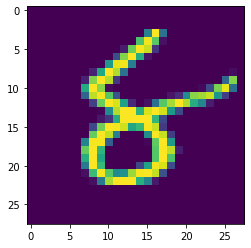

In [ ]:
plt.imshow(tf.squeeze(x[10])) # squeeze removes dimension of size 1 like (28,28,1) -> (28,28)

## GET PREDICTION from TEACHER model for particular INPUT

In [ ]:
pred=teacher_load(tf.expand_dims(x[10], axis=0)) # expand dimension to add a dimension like (1,28,28,1) as Hidden layers in model expecting such iamge dimension

In [ ]:
tf.nn.softmax(pred)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[1.5840317e-15, 5.8273717e-16, 9.6660402e-11, 2.5453294e-12,
        3.5349616e-14, 6.2031831e-06, 4.7944656e-07, 4.5804319e-17,
        9.9999332e-01, 1.1883043e-13]], dtype=float32)>

## GET PREDICTION from STUDENT with KD model for particular INPUT

In [ ]:
pred_stud=student_kd_load(tf.expand_dims(x[10], axis=0))
tf.nn.softmax(pred_stud)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[5.4173426e-11, 3.2843146e-13, 3.0727740e-08, 5.7113897e-10,
        1.3864884e-11, 1.8106535e-05, 1.0972422e-05, 4.8239594e-14,
        9.9997091e-01, 2.6448049e-10]], dtype=float32)>

## GET PREDICTION from STUDENT without KD model for particular INPUT

In [ ]:
pred_stud_no_kd=student_wo_kd_load(tf.expand_dims(x[10], axis=0))
tf.nn.softmax(pred_stud_no_kd)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[0.08537059, 0.08537059, 0.08537208, 0.08537062, 0.08537059,
        0.0855987 , 0.08537276, 0.08537059, 0.23143291, 0.0853706 ]],
      dtype=float32)>

### experiment for new KD algo

In [ ]:
pred_TA_new_kd=teacher_ast(tf.expand_dims(x[121], axis=0))
pred_TA_new_kd

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[2.3455229e-06, 5.4232383e-09, 1.2715701e-04, 1.4000888e-07,
        4.3723307e-07, 3.4421989e-06, 9.9983501e-01, 8.9060301e-11,
        3.1458199e-05, 4.2948280e-08]], dtype=float32)>

In [ ]:
pred_T_new_kd=teacher_test(tf.expand_dims(x[121], axis=0))
pred_T_new_kd

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[2.5209340e-07, 2.4002370e-11, 8.2260233e-11, 1.5573476e-12,
        1.0507798e-08, 1.8939144e-06, 9.9999702e-01, 4.5038748e-13,
        8.3604112e-07, 1.5623920e-10]], dtype=float32)>

In [ ]:
pred_stud_new_kd=student_2_kdd(tf.expand_dims(x[121], axis=0))
pred_stud_new_kd

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[5.58025988e-07, 8.45970030e-11, 8.24307904e-07, 4.93703922e-08,
        6.84622208e-08, 1.83246016e-07, 9.99970078e-01, 1.06028345e-13,
        2.82654146e-05, 7.48049089e-09]], dtype=float32)>

## SHAP

In [7]:
!pip install shap

In [8]:
import numpy as np

import shap

In [ ]:
tf.expand_dims(x, axis=0)

In [ ]:
#https://shap-lrjball.readthedocs.io/en/latest/example_notebooks/gradient_explainer/Multi-input%20Gradient%20Explainer%20MNIST%20Example.html


In [13]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

# More SHAP references:

In [ ]:
# https://www.kaggle.com/code/dansbecker/shap-values/tutorial



In [ ]:
# https://analyticsindiamag.com/hands-on-guide-to-interpret-machine-learning-with-shap/


In [ ]:
# https://dev.to/mage_ai/how-to-interpret-machine-learning-models-with-shap-values-54jf


## TEACHER explanation

### Teacher for Digit 0

In [ ]:
teacher_load=load_model('./teacher_model.h5')
teacher_load.load_weights('./teacher_model_weight')

In [ ]:
explainer_teacher=shap.GradientExplainer(teacher_load,x)
image0 = tf.expand_dims(x[11], axis=0)
explainables_teacher0 = explainer_teacher.shap_values(image0,200)

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


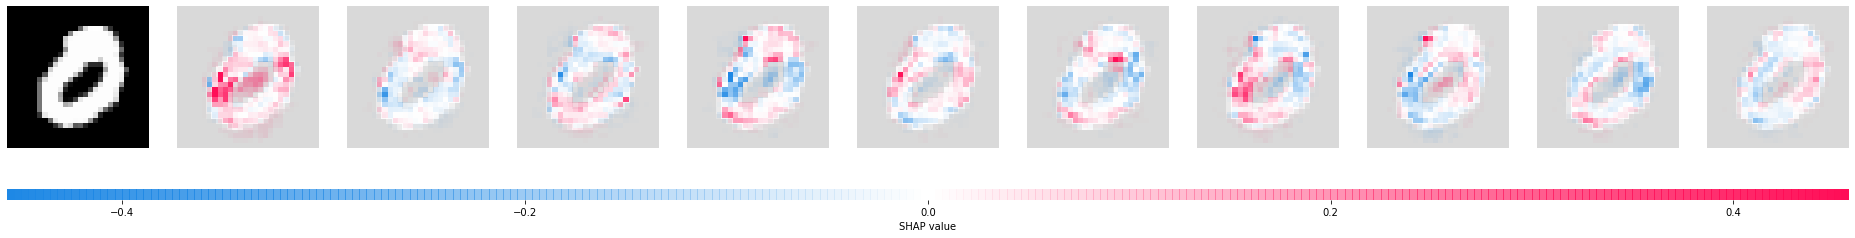

In [ ]:

shap.image_plot([np.array(explainables_teacher0[i]) for i in range(10) ],np.array(tf.expand_dims(x[11], axis=0)),width=400, labelpad=float)

In [ ]:
pred_teach0=teacher_load(image0,training=False)
tf.nn.softmax(pred_teach0)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[9.9999833e-01, 2.6526728e-10, 4.9149094e-07, 5.0761578e-10,
        3.7596973e-07, 6.8374945e-10, 4.5435365e-07, 8.5595037e-10,
        7.7023863e-09, 3.8589042e-07]], dtype=float32)>

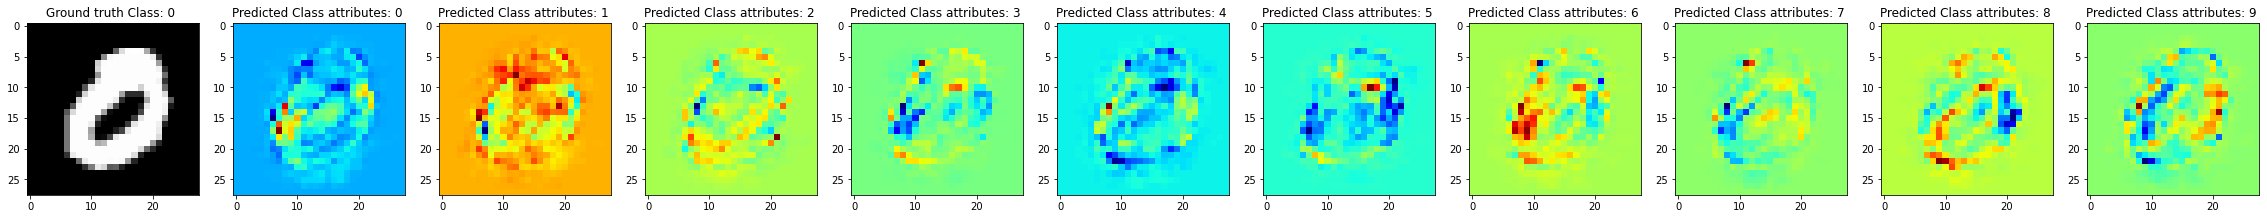

In [ ]:
fig1 = plt.figure(figsize=(40,40))
plt.subplot(1,11,1)
plt.imshow(tf.squeeze(x[11]),cmap='gray')
plt.title('Ground truth Class: %d '% np.array(tf.argmax(y[11])))
for a in range(10):
  plt.subplot(1,11,a+2)
  plt.imshow(tf.squeeze(explainables_teacher0[a]),cmap='jet')
  plt.title('Predicted Class attributes: %d '% a)


### Teacher for Digit 2

In [ ]:
image9 = tf.expand_dims(x[43], axis=0)
explainables_teacher9 = explainer_teacher.shap_values(image9,200)

In [ ]:
pred_teach9=teacher_load(image9,training=False)
tf.nn.softmax(pred_teach9)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[5.1760674e-10, 2.7420941e-12, 1.0000000e+00, 1.0179581e-09,
        1.1753436e-14, 1.4225048e-18, 6.2098283e-16, 2.0884133e-11,
        8.9067351e-11, 1.6741811e-14]], dtype=float32)>

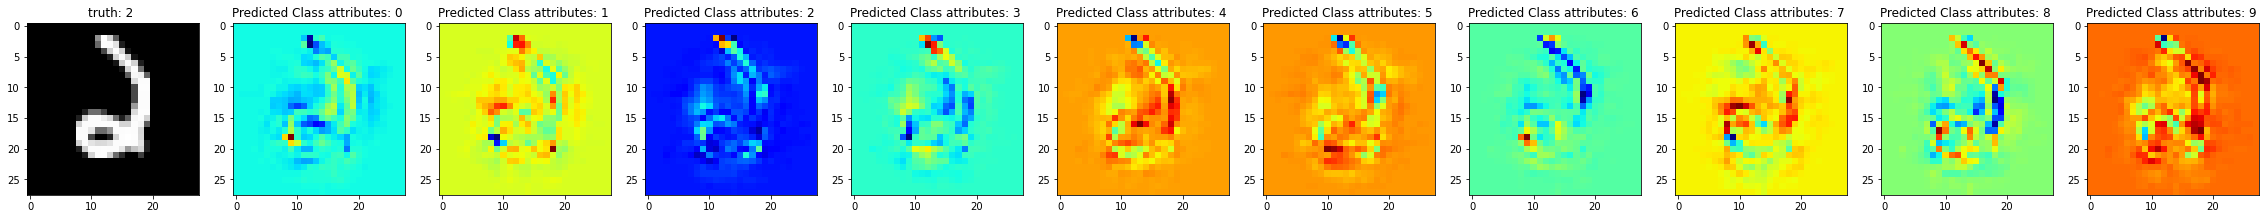

In [ ]:
fig1 = plt.figure(figsize=(40,40))
plt.subplot(1,11,1)
plt.imshow(tf.squeeze(x[43]),cmap='gray')
plt.title('truth: %d ' % np.array(tf.argmax(y[43])))
for a in range(10):
  plt.subplot(1,11,a+2)
  plt.imshow(tf.squeeze(explainables_teacher9[a]),cmap='jet')
  plt.title('Predicted Class attributes: %d '% a)

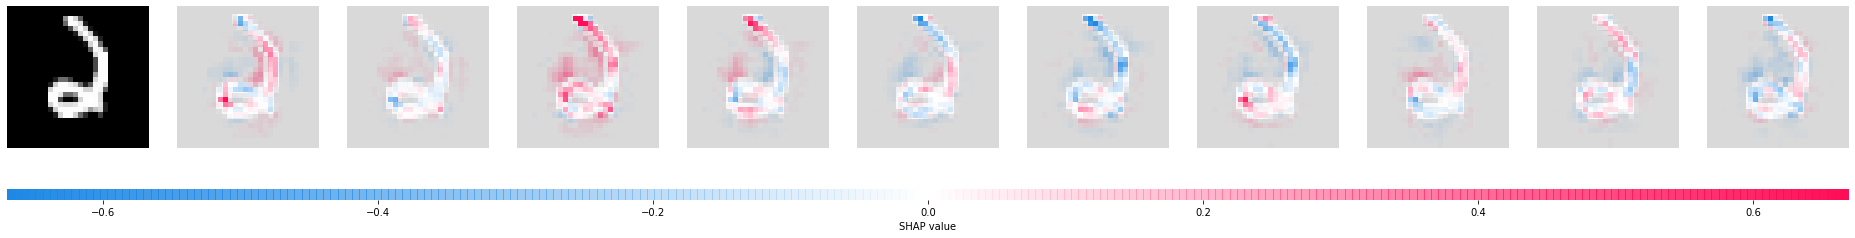

In [ ]:
shap.image_plot([np.array(explainables_teacher9[i]) for i in range(10) ],np.array(tf.expand_dims(x[43], axis=0)),width=400, labelpad=float)

## STUDENT explanation

### Student Distill for Digit 0

In [ ]:
student_kd_load=load_model('./student_kd_temp4.h5')
student_kd_load.load_weights('./student_kd_temp4_weight')

In [ ]:
explainer_student=shap.GradientExplainer(student_kd_load,x)
explainables_student0 = explainer_student.shap_values(image0,200)

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [ ]:
pred_stud0=student_kd_load(image0,training=False)
tf.nn.softmax(pred_stud0)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[9.99999404e-01, 2.54524891e-11, 5.50067760e-08, 1.50502163e-11,
        2.39315966e-07, 1.09613596e-10, 1.45580429e-07, 5.58226416e-11,
        6.22636442e-10, 6.13204989e-08]], dtype=float32)>

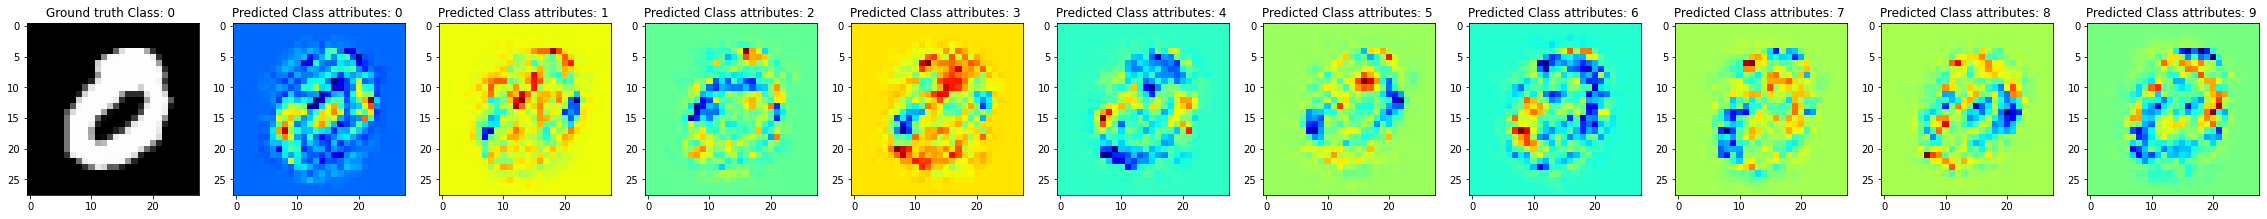

In [ ]:
fig1 = plt.figure(figsize=(40,40))
plt.subplot(1,11,1)
plt.imshow(tf.squeeze(x[11]),cmap='gray')
plt.title('Ground truth Class: %d '% np.array(tf.argmax(y[11])))
for a in range(10):
  plt.subplot(1,11,a+2)
  plt.imshow(tf.squeeze(explainables_student0[a]),cmap='jet')
  plt.title('Predicted Class attributes: %d '% a)


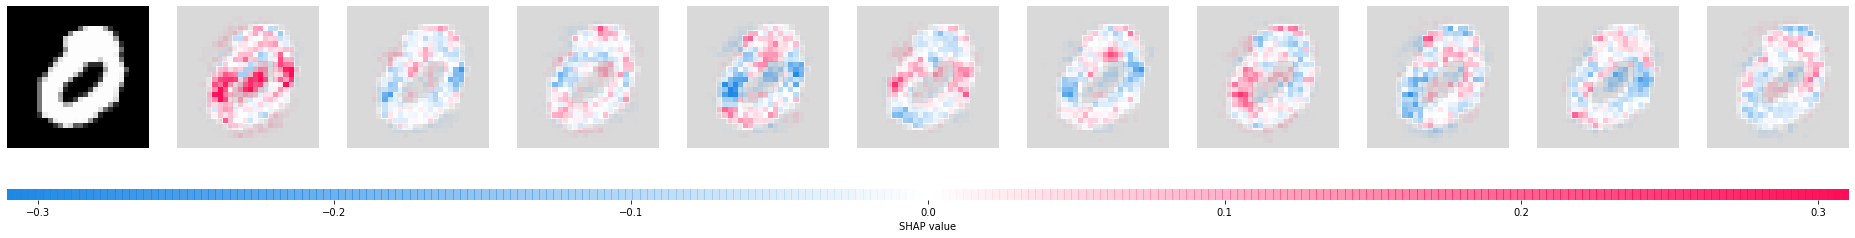

In [ ]:
shap.image_plot([np.array(explainables_student0[i]) for i in range(10) ],np.array(tf.expand_dims(x[11], axis=0)),width=400, labelpad=float)

### Student Distill for Digit 2

In [ ]:
explainables_student9 = explainer_student.shap_values(image9,200)

In [ ]:
pred_stud9=student_kd_load(image9,training=False)
tf.nn.softmax(pred_stud9)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[5.8953897e-10, 1.5330183e-11, 1.0000000e+00, 3.3068577e-09,
        2.7121941e-13, 4.9095843e-17, 5.7373082e-15, 5.8839052e-11,
        7.5886623e-11, 3.8248925e-14]], dtype=float32)>

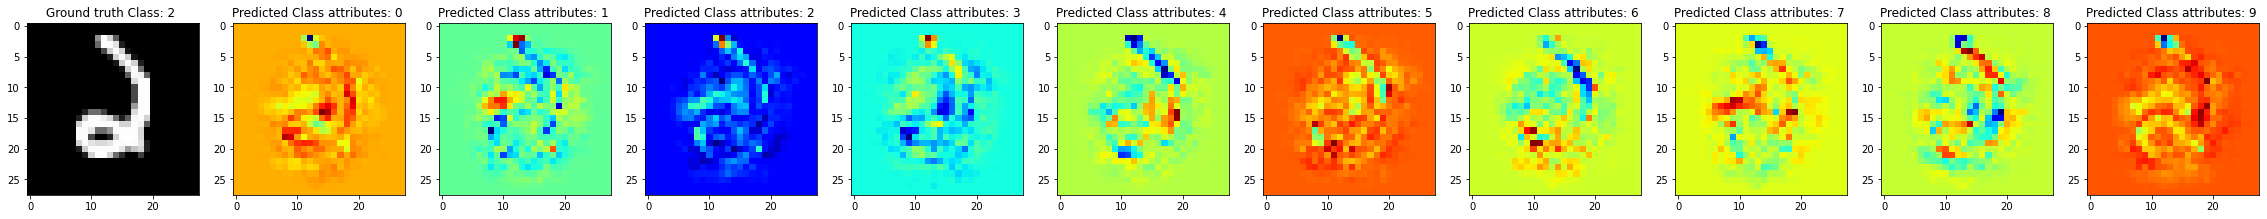

In [ ]:
fig1 = plt.figure(figsize=(40,40))
plt.subplot(1,11,1)
plt.imshow(tf.squeeze(x[43]),cmap='gray')
plt.title('Ground truth Class: %d '% np.array(tf.argmax(y[43])))
for a in range(10):
  plt.subplot(1,11,a+2)
  plt.imshow(tf.squeeze(explainables_student9[a]),cmap='jet')
  plt.title('Predicted Class attributes: %d '% a)


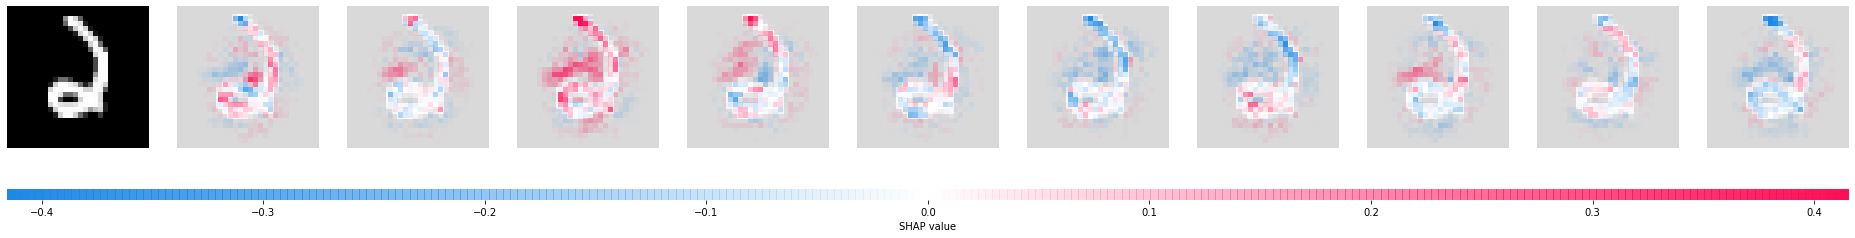

In [ ]:
shap.image_plot([np.array(explainables_student9[i]) for i in range(10) ],np.array(tf.expand_dims(x[43], axis=0)),width=400, labelpad=float)

## Student without Distillation Explanation

### Student WO KD Digit 0

In [ ]:
student_wo_kd_load=load_model('./student_wo_kd_temp4.h5')
student_wo_kd_load.load_weights('./student_wo_kd_temp4_weight')

In [ ]:
explainer_student=shap.GradientExplainer(student_wo_kd_load,x)
explainables_student0_wokd = explainer_student.shap_values(image0,200)

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [ ]:
pred_stud0_wokd=student_wo_kd_load(image0,training=False)
tf.nn.softmax(pred_stud0_wokd)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[1.0000000e+00, 3.7817562e-38, 2.0397676e-25, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 1.3579641e-26, 1.2371417e-36,
        1.9775327e-31, 6.5773864e-28]], dtype=float32)>

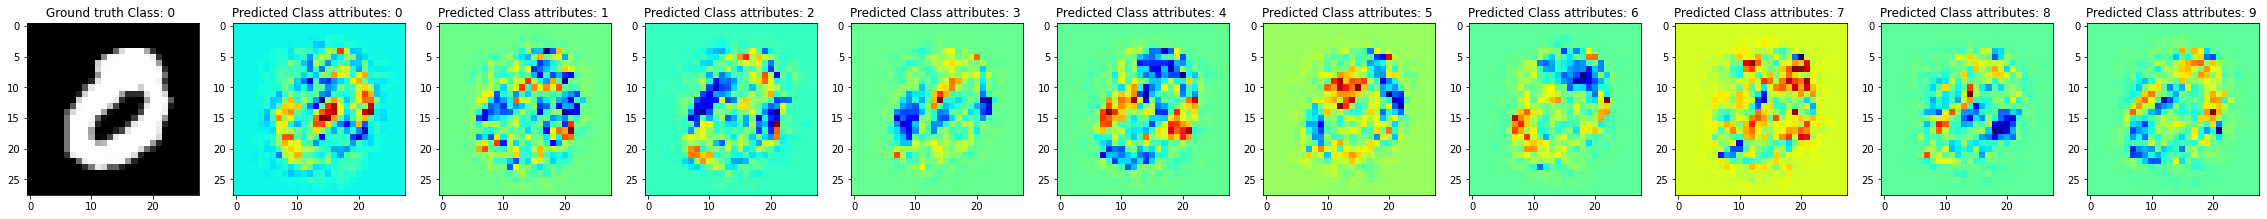

In [ ]:
fig1 = plt.figure(figsize=(40,40))
plt.subplot(1,11,1)
plt.imshow(tf.squeeze(x[11]),cmap='gray')
plt.title('Ground truth Class: %d '% np.array(tf.argmax(y[11])))
for a in range(10):
  plt.subplot(1,11,a+2)
  plt.imshow(tf.squeeze(explainables_student0_wokd[a]),cmap='jet')
  plt.title('Predicted Class attributes: %d '% a)


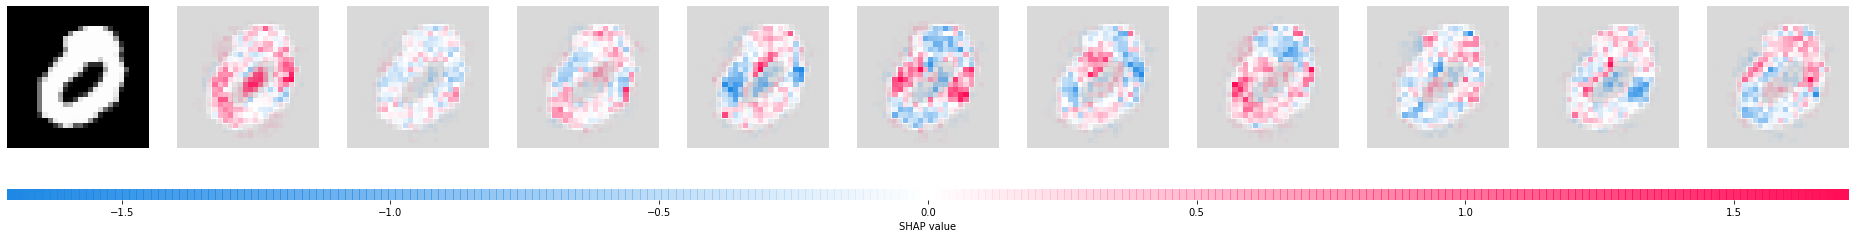

In [ ]:
shap.image_plot([np.array(explainables_student0_wokd[i]) for i in range(10) ],np.array(tf.expand_dims(x[11], axis=0)),width=400, labelpad=float)

### Student WO KD Digit 2

In [ ]:
explainables_student9_wokd = explainer_student.shap_values(image9,200)

In [ ]:
pred_stud2_wokd=student_wo_kd_load(image9,training=False)
tf.nn.softmax(pred_stud2_wokd)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[7.2600856e-37, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)>

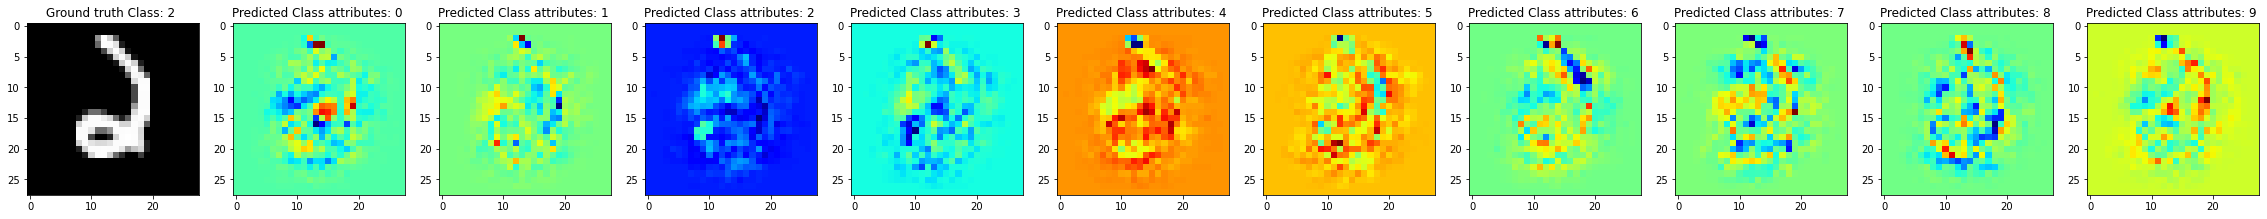

In [ ]:
fig1 = plt.figure(figsize=(40,40))
plt.subplot(1,11,1)
plt.imshow(tf.squeeze(x[43]),cmap='gray')
plt.title('Ground truth Class: %d '% np.array(tf.argmax(y[43])))
for a in range(10):
  plt.subplot(1,11,a+2)
  plt.imshow(tf.squeeze(explainables_student9_wokd[a]),cmap='jet')
  plt.title('Predicted Class attributes: %d '% a)


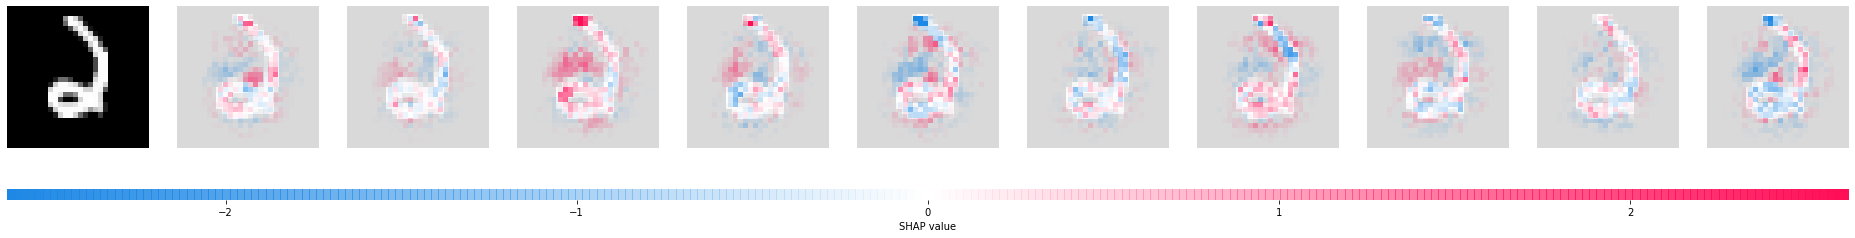

In [ ]:
shap.image_plot([np.array(explainables_student9_wokd[i]) for i in range(10) ],np.array(tf.expand_dims(x[43], axis=0)),width=400, labelpad=float)

# Implementing TAKD

In [ ]:
# your code start from here for step 13


## Models for new KD

### Teacher assistant for new kd loss: 0.0616 - accuracy: 0.9817 - val_loss: 0.0554 - val_accuracy: 0.9835

In [22]:
teacher_ast = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(32, (3, 3), strides=(1, 1), padding="same"),
        layers.ReLU(),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        # layers.Conv2D(64, (3, 3), strides=(1, 1), padding="same"),
        # layers.ReLU(),
        #layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(64, activation="relu"),
        # layers.Dropout(0.5),
        layers.Dense(10)
    ],
    name="teacher_ast",
)

In [23]:
teacher_ast.summary()

Model: "teacher_ast"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 re_lu_5 (ReLU)              (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 28, 28, 32)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_5 (Dropout)         (None, 25088)             0         
                                                                 
 dense_6 (Dense)             (None, 64)                1605696   
                                                       

### Teacher for new kd loss: 0.0500 - accuracy: 0.9848 - val_loss: 0.0267 - val_accuracy: 0.9916

In [20]:
teacher_new_kd = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(32, (3, 3), strides=(1, 1), padding="same"),
        layers.ReLU(),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        layers.Conv2D(64, (3, 3), strides=(1, 1), padding="same"),
        layers.ReLU(),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(10)
    ],
    name="teacher_new_kd",
)

In [21]:
teacher_new_kd.summary()

Model: "teacher_new_kd"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 re_lu_3 (ReLU)              (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 28, 28, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 re_lu_4 (ReLU)              (None, 28, 28, 64)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                

### Student fro new kd  loss: 0.0243 - accuracy: 0.9921 - val_loss: 0.0673 - val_accuracy: 0.9805

In [24]:
student_new_kd = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Flatten(),
        layers.Dense(784, activation="relu"),
        layers.Dense(784, activation="relu"),
        layers.Dense(10)

    ],
    name="student_new_kd",
)


In [25]:
student_new_kd.summary()

Model: "student_new_kd"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dense_8 (Dense)             (None, 784)               615440    
                                                                 
 dense_9 (Dense)             (None, 784)               615440    
                                                                 
 dense_10 (Dense)            (None, 10)                7850      
                                                                 
Total params: 1,238,730
Trainable params: 1,238,730
Non-trainable params: 0
_________________________________________________________________


In [27]:

def compute_teacher_loss_new_kd(images, labels,temperature,alpha):
  """Compute class knowledge distillation teacher loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  

  # Compute cross-entropy loss for classes.

  # your code start from here for step 3
  class_logits_new_kd = teacher_new_kd(images, training=True)
  cross_entropy_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels,class_logits_new_kd))

  return cross_entropy_loss_value

In [26]:
def distillation_loss_new_kd(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
  """Compute distillation loss.

  This function computes cross entropy between softened logits and softened
  targets. The resulting loss is scaled by the squared temperature so that
  the gradient magnitude remains approximately constant as the temperature is
  changed. For reference, see Hinton et al., 2014, "Distilling the knowledge in
  a neural network."

  Args:
    teacher_logits: A Tensor of logits provided by the teacher.
    student_logits: A Tensor of logits provided by the student, of the same
      shape as `teacher_logits`.
    temperature: Temperature to use for distillation.

  Returns:
    A scalar Tensor containing the distillation loss.
  """
 # your code start from here for step 3
  soft_targets_2 = teacher_logits / temperature
  soft_targets_2 =tf.nn.softmax(soft_targets_2)
  return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          soft_targets_2, student_logits / temperature))*temperature**2
  #* temperature ** 2

def compute_TA_loss_new_kd(images, labels,temperature,alpha):
  """Compute class knowledge distillation student loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  ta_class_logits_2 = teacher_ast(images, training=True)

  # Compute class distillation loss between student class logits and
  # softened teacher class targets probabilities.

  # your code start from here for step 3

  # teacher_class_logits_2 = teacher_new_kd(images, training=False)
  

  # Compute cross-entropy loss with hard targets.

  # your code start from here for step 3

  teacher_class_logits_2 = teacher_new_kd(images, training=False)
  distillation_loss_value_2 =distillation_loss_new_kd(teacher_class_logits_2,ta_class_logits_2,temperature)
  cross_entropy_loss_value_2 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, ta_class_logits_2))

  total_loss_2 =alpha*cross_entropy_loss_value_2 + (1-alpha)*distillation_loss_value_2

  return total_loss_2

In [28]:

def compute_student_loss_new_kd(images, labels,temperature,alpha):
  """Compute class knowledge distillation student loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  

  # Compute class distillation loss between student class logits and
  # softened teacher class targets probabilities.

  # your code start from here for step 3


  # Compute cross-entropy loss with hard targets.

  # your code start from here for step 3
  student_class_logits_2 = student_new_kd(images, training=True)
  ta_class_logits_3 = teacher_ast(images, training=False)
  distillation_loss_value_3 =distillation_loss_new_kd(ta_class_logits_3,student_class_logits_2,temperature)
 
  cross_entropy_loss_value_3 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, ta_class_logits_3))

  total_loss_3 =alpha*cross_entropy_loss_value_3 + (1-alpha)*distillation_loss_value_3

  return total_loss_3

## New KD training sequence

### Teacher train

In [30]:
temp2=4
learning_rate=0.001
alpha=0.5
print("Teacher New KD training")
train_and_evaluate(teacher_new_kd, compute_teacher_loss_new_kd,temp2,learning_rate,alpha)
# teacher.save("teacher_model_new_kd.h5")
# teacher.save_weights("teacher_model_new_kd_weight")

Teacher New KD training
Epoch 1: Class_accuracy: 98.04%
Epoch 2: Class_accuracy: 98.69%
Epoch 3: Class_accuracy: 98.85%
Epoch 4: Class_accuracy: 99.03%
Epoch 5: Class_accuracy: 99.07%
Epoch 6: Class_accuracy: 99.22%
Epoch 7: Class_accuracy: 99.21%
Epoch 8: Class_accuracy: 99.14%
Epoch 9: Class_accuracy: 99.07%
Epoch 10: Class_accuracy: 99.19%
Epoch 11: Class_accuracy: 99.25%
Epoch 12: Class_accuracy: 99.29%


### TA train

In [50]:
#teacher_new_kd_load=load_model('./teacher_model_new_kd.h5')
#teacher_new_kd_load.load_weights('./teacher_model_new_kd_weight')

In [32]:
temp2=4
learning_rate=0.001
alpha=0.5
print("TA distill training")
train_and_evaluate(teacher_ast, compute_TA_loss_new_kd,temp2,learning_rate,alpha)
teacher_ast.save("TA_model_new_kd.h5")
teacher_ast.save_weights("TA_model_new_kd_weight")

TA distill training
Epoch 1: Class_accuracy: 97.10%
Epoch 2: Class_accuracy: 98.04%
Epoch 3: Class_accuracy: 98.31%
Epoch 4: Class_accuracy: 98.45%
Epoch 5: Class_accuracy: 98.63%
Epoch 6: Class_accuracy: 98.68%
Epoch 7: Class_accuracy: 98.60%
Epoch 8: Class_accuracy: 98.69%
Epoch 9: Class_accuracy: 98.88%
Epoch 10: Class_accuracy: 98.85%
Epoch 11: Class_accuracy: 98.80%
Epoch 12: Class_accuracy: 98.86%


### Student train

In [33]:
temp2=4
learning_rate=0.001
alpha=0.5
print("Student distill training")
train_and_evaluate(student_new_kd, compute_student_loss_new_kd,temp2,learning_rate,alpha)
student_new_kd.save("student_model_new_kd.h5")
student_new_kd.save_weights("student_model_new_kd_weight")

Student distill training
Epoch 1: Class_accuracy: 96.60%
Epoch 2: Class_accuracy: 97.63%
Epoch 3: Class_accuracy: 98.08%
Epoch 4: Class_accuracy: 98.34%
Epoch 5: Class_accuracy: 98.34%
Epoch 6: Class_accuracy: 98.48%
Epoch 7: Class_accuracy: 98.47%
Epoch 8: Class_accuracy: 98.58%
Epoch 9: Class_accuracy: 98.51%
Epoch 10: Class_accuracy: 98.55%
Epoch 11: Class_accuracy: 98.67%
Epoch 12: Class_accuracy: 98.63%


## SHAP on TAKD

### LOAD TAKD models

In [32]:
teacher_new_kd_load=load_model('./teacher_model_new_kd.h5')
teacher_new_kd_load.load_weights('./teacher_model_new_kd_weight')
TA_new_kd_load=load_model('./TA_model_new_kd.h5')
TA_new_kd_load.load_weights('./TA_model_new_kd_weight')
student_new_kd_load=load_model('./student_model_new_kd.h5')
student_new_kd_load.load_weights('./student_model_new_kd_weight')

In [38]:
flops_teacher2 = get_flops(teacher_new_kd_load, batch_size=1)
print(f"FLOPS: {flops_teacher2 / 10 ** 9:.03} G")

Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


FLOPS: 0.0328 G


In [39]:
flops_TA2 = get_flops(TA_new_kd_load, batch_size=1)
print(f"FLOPS: {flops_TA2 / 10 ** 9:.03} G")

FLOPS: 0.00379 G


In [40]:
flops_student2 = get_flops(student_new_kd_load, batch_size=1)
print(f"FLOPS: {flops_student2 / 10 ** 9:.03} G")

FLOPS: 0.00248 G


### Teacher Digit 2 classification

In [14]:
explainer_teacher_new_kd=shap.GradientExplainer(teacher_new_kd_load,x)
image2 = tf.expand_dims(x[43], axis=0)
explainables_teacher2_new_kd = explainer_teacher_new_kd.shap_values(image2,200)

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [15]:
pred_teach2=teacher_new_kd_load(image2)
tf.nn.softmax(pred_teach2)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[7.9726094e-11, 5.3280110e-14, 1.0000000e+00, 5.5162958e-11,
        5.6765048e-15, 8.1467649e-17, 2.2588795e-15, 1.3540933e-13,
        2.3033927e-11, 9.9969052e-17]], dtype=float32)>

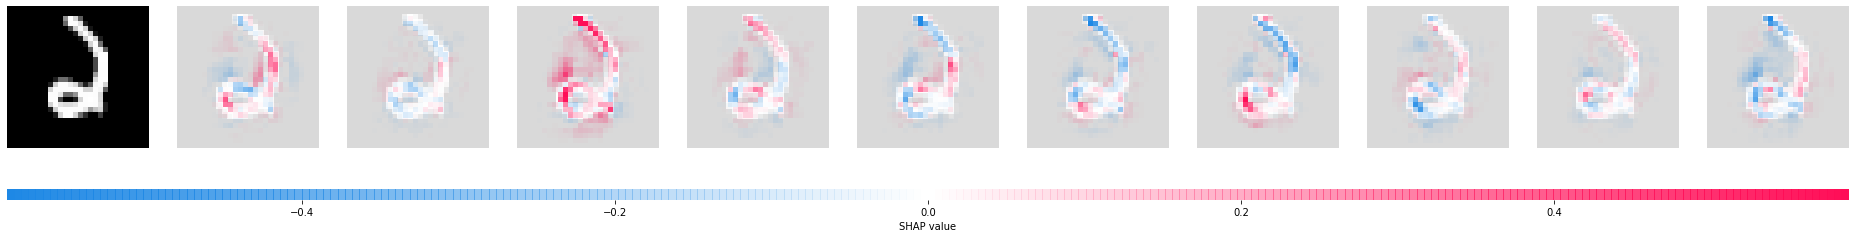

In [16]:
shap.image_plot([np.array(explainables_teacher2_new_kd[i]) for i in range(10) ],np.array(tf.expand_dims(x[43], axis=0)),width=400, labelpad=float)

### TA Digit 2 classification

In [17]:
explainer_TA_new_kd=shap.GradientExplainer(TA_new_kd_load,x)
image2 = tf.expand_dims(x[43], axis=0)
explainables_TA2_new_kd = explainer_TA_new_kd.shap_values(image2,200)

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [18]:
pred_TA2=TA_new_kd_load(image2,training=False)
tf.nn.softmax(pred_TA2)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[4.4945753e-10, 3.1466941e-12, 1.0000000e+00, 1.3818117e-10,
        9.5260052e-13, 1.6352855e-15, 6.3095536e-13, 1.1487006e-12,
        7.7733209e-11, 2.7053716e-15]], dtype=float32)>

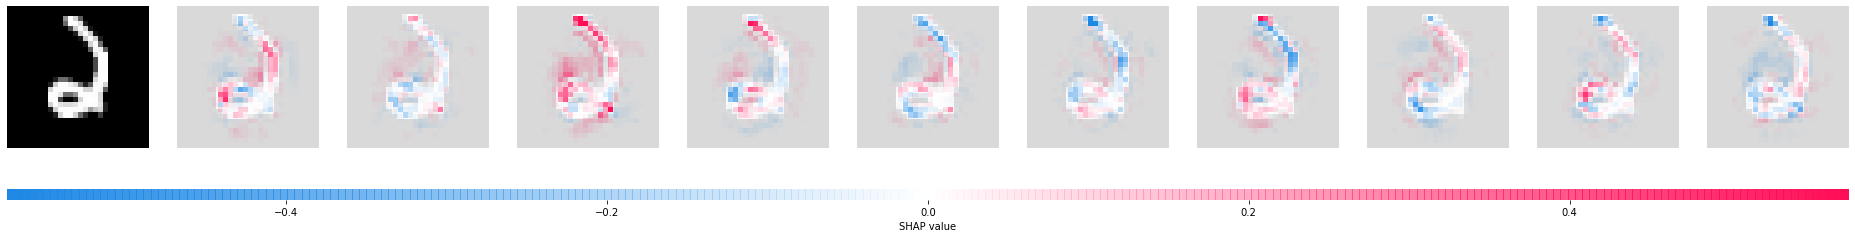

In [19]:
shap.image_plot([np.array(explainables_TA2_new_kd[i]) for i in range(10) ],np.array(tf.expand_dims(x[43], axis=0)),width=400, labelpad=float)

### Student Digit 2 classification

In [20]:
explainer_student_new_kd=shap.GradientExplainer(student_new_kd_load,x)
image2 = tf.expand_dims(x[43], axis=0)
explainables_student2_new_kd = explainer_student_new_kd.shap_values(image2,200)

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [21]:
pred_student2_new=student_new_kd_load(image2)
tf.nn.softmax(pred_student2_new)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[3.1266985e-09, 2.4320823e-12, 1.0000000e+00, 6.3079111e-11,
        6.4624700e-13, 3.5537568e-15, 2.4005600e-11, 4.3055495e-13,
        7.5207507e-11, 2.8240762e-15]], dtype=float32)>

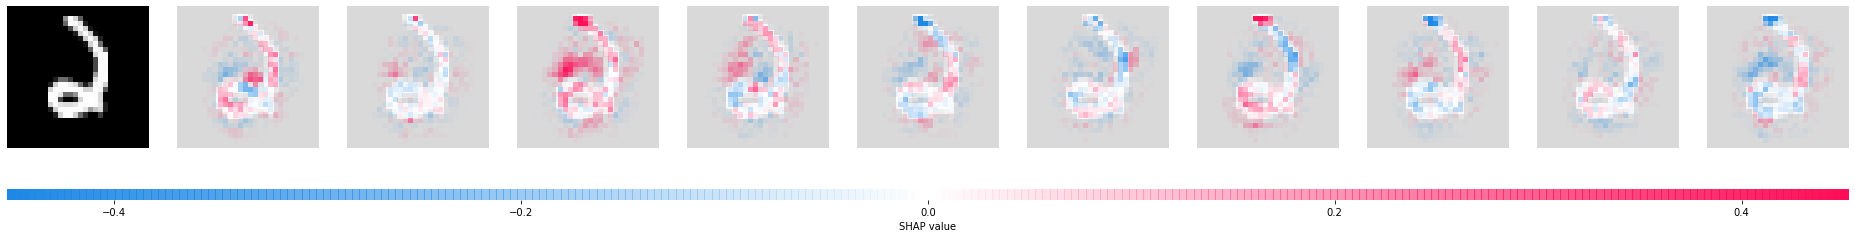

In [22]:
shap.image_plot([np.array(explainables_student2_new_kd[i]) for i in range(10) ],np.array(tf.expand_dims(x[43], axis=0)),width=400, labelpad=float)